# Facial Recognition
Section 1: Running the TensorFlow SavedModel on Computer Inference


Section 2: Converting SavedModel to TensorFlowLite for Mobile Inference


# **Section 1: Computer Inference and Setup**

Imports

In [ ]:
!pip install -U tensorflow

In [ ]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 3192, done.
remote: Counting objects: 100% (3192/3192), done.
remote: Compressing objects: 100% (2694/2694), done.
remote: Total 3192 (delta 848), reused 1372 (delta 455), pack-reused 0
Receiving objects: 100% (3192/3192), 33.39 MiB | 25.98 MiB/s, done.
Resolving deltas: 100% (848/848), done.


In [ ]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-py3-none-any.whl size=1680866 sha256=cf2a469b8ca6c31018f875bb739b77c60293f2ddd0794f20c99eaedb932f8cd3
  Stored in directory: /tmp/pip-ephem-wheel-cache-c2kqtsz9/wheels/fa/a4/d2/e9a5057e414fd46c8e543d2706cd836d64e1fcd9eccceb2329
  Created wheel for py-cpuinfo: filename=py_cpuinfo-8.0.0-py3-none-any.whl size=22258 sha256=5c81cde9b641b0584a9c6c88de5b53f5b4fce5a1d13fb7c986f226c241c98624
  Stored in directory: /root/.cache/pip/wheels/d2/f1/1f/041add21dc9c4220157f1bd2bd6afe1f1a49524c3396b94401
  Created wheel for avro-python3: filename=avro_python3-1.9.2.1-py3-none-any.whl size=43512 sha256=b069e3cc8256c63c862c8e687c7a63c188e19b1a82bf4cf0775ca38781d57b9b
  Stored in directory: /root/.cache/pip/wheels/bc/49/5f/fdb5b9d85055c478213e0158ac122b596816149a02d82e0ab1
  Created wheel for dill: filename=dill-0.3.1.1-py3-none-any.whl size=78546 sha256=b4f7e7d84311350bbf790c3c70c48f6b0c67deb256dead3b0

  DEPRECATION: A future pip version will change local packages to be built in-place without first copying to a temporary directory. We recommend you use --use-feature=in-tree-build to test your packages with this new behavior before it becomes the default.
   pip 21.3 will remove support for this functionality. You can find discussion regarding this at https://github.com/pypa/pip/issues/7555.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
multiprocess 0.70.12.2 requires dill>=0.3.4, but you have dill 0.3.1.1 which is incompatible.
google-colab 1.0.0 requires requests~=2.23.0, but you have requests 2.26.0 which is incompatible.
datascience 0.10.6 requires folium==0.2.1, but you have folium 0.8.3 which is incompatible.


In [ ]:
import io
import os
import scipy.misc
import numpy as np
import six
import time

from six import BytesIO

import matplotlib
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf
from object_detection.utils import visualization_utils as viz_utils

%matplotlib inline

In [ ]:
def load_image_into_numpy_array(path):
  # Load image into numpy array
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: a file path (this can be local or on colossus)

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

# Load the ADAS Label map
category_index = {
    1: {'id': 1, 'name': 'JC'},
    2: {'id': 2, 'name': 'PK'},
}

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
# Load the Model (should be saved in google drive under the path below)
start_time = time.time()
tf.keras.backend.clear_session()
detect_fn = tf.saved_model.load('/content/drive/MyDrive/Training/12_05_JCPK/saved_model')
end_time = time.time()
elapsed_time = end_time - start_time
print('Elapsed time: ' + str(elapsed_time) + 's')

Elapsed time: 23.85128378868103s


Elapsed time: 0.060425639152526855 second per image


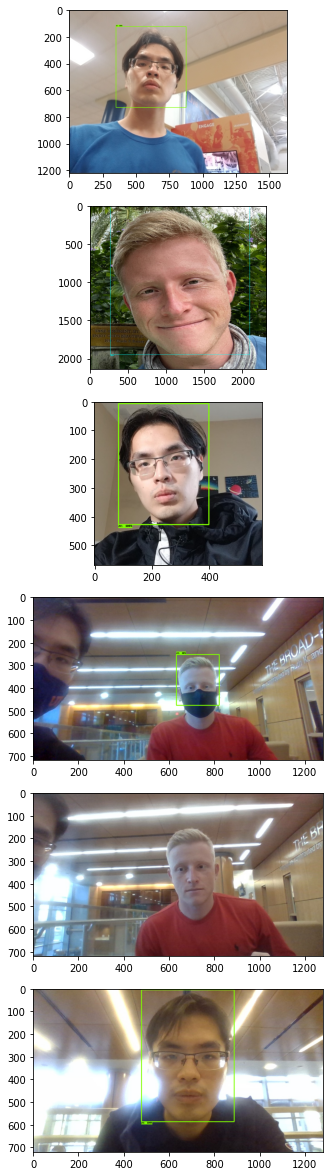

In [ ]:
import time

image_dir = '/content/drive/MyDrive/Training Images'

elapsed = []
for i in range(6):
  image_path = os.path.join(image_dir, 'image' + str(i + 1) + '.jpg')
  image_np = load_image_into_numpy_array(image_path)
  input_tensor = np.expand_dims(image_np, 0)
  start_time = time.time()
  detections = detect_fn(input_tensor)
  end_time = time.time()
  elapsed.append(end_time - start_time)

  plt.rcParams['figure.figsize'] = [42, 21]
  label_id_offset = 1
  image_np_with_detections = image_np.copy()
  viz_utils.visualize_boxes_and_labels_on_image_array(
        image_np_with_detections,
        detections['detection_boxes'][0].numpy(),
        detections['detection_classes'][0].numpy().astype(np.int32),
        detections['detection_scores'][0].numpy(),
        category_index,
        use_normalized_coordinates=True,
        max_boxes_to_draw=200,
        min_score_thresh=.40,
        agnostic_mode=False)
  plt.subplot(6, 1, i+1)
  plt.imshow(image_np_with_detections)

mean_elapsed = sum(elapsed) / float(len(elapsed))
print('Elapsed time: ' + str(mean_elapsed) + ' second per image')



In [ ]:
  det_class = detections['detection_classes'][0].numpy().astype(np.int32)
  det_scores = detections['detection_scores'][0].numpy()
  print(det_class)
  print(det_scores)

[1 2 2 2 2 1 1 1 2 2 2 2 1 2 1 1 2 1 1 1 1 2 1 2 2 1 1 2 2 1 1 2 1 2 1 1 1
 2 2 2 1 2 2 1 1 2 1 2 2 2 1 2 2 1 2 1 1 1 1 1 1 2 1 1 1 1 1 2 1 1 2 2 2 2
 1 2 2 1 1 1 2 2 2 1 2 1 2 1 1 2 2 2 1 1 2 2 1 1 2 2]
[0.9997155  0.17390653 0.02384767 0.02091455 0.01539558 0.01457479
 0.01067743 0.01048775 0.01047633 0.01031933 0.00937459 0.00912222
 0.00858967 0.00855748 0.00847966 0.00820144 0.00790882 0.00712707
 0.0069775  0.00687591 0.00661067 0.00641518 0.00635879 0.0063028
 0.00607781 0.00592671 0.00582509 0.00574954 0.00565693 0.00552448
 0.00548091 0.00548062 0.00541679 0.00541579 0.00540082 0.00535403
 0.00531629 0.00526596 0.00526075 0.00514584 0.00513263 0.0051321
 0.00498143 0.00497101 0.00495221 0.0048355  0.00457174 0.00456723
 0.00454304 0.00451978 0.00449952 0.00447159 0.00441729 0.00439743
 0.00429924 0.00426606 0.00421604 0.00417825 0.00410064 0.00405695
 0.00401293 0.00399653 0.00399345 0.00397598 0.00390842 0.00384597
 0.00382254 0.0037941  0.00378656 0.00374077 0.00370142 0.003

### Install the TFLite Support Library

In [ ]:
!pip install -q tflite_support
!pip install tensorflow

In [ ]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.utils import config_util
from object_detection.builders import model_builder

%matplotlib inline

## **Section 2: TensorFlowLite Conversion**

### Step 1: Export TFLite inference graph

First, we invoke `export_tflite_graph_tf2.py` to generate a TFLite-friendly intermediate SavedModel. This will then be passed to the TensorFlow Lite Converter for generating the final model.

Use `--help` with the above script to get the full list of supported parameters.
These can fine-tune accuracy and speed for your model.

In [ ]:
!python models/research/object_detection/export_tflite_graph_tf2.py \
    --trained_checkpoint_dir {'/content/drive/MyDrive/Training/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/checkpoint'} \
    --output_directory {'/content/drive/MyDrive/Training/mobilenet_tflite'} \
    --pipeline_config_path {'/content/drive/MyDrive/Training/ssd_mobilenet_v2_fpnlite_640x640_coco17_tpu-8/pipeline.config'}

### Step 2: Convert to TFLite

Use the [TensorFlow Lite Converter](https://www.tensorflow.org/lite/convert) to
convert the `SavedModel` to TFLite. Note that you need to use `from_saved_model`
for TFLite conversion with the Python API.

You can also leverage
[Post-training Quantization](https://www.tensorflow.org/lite/performance/post_training_quantization)
to
[optimize performance](https://www.tensorflow.org/lite/performance/model_optimization)
and obtain a smaller model. In this tutorial, we use the [dynamic range quantization](https://www.tensorflow.org/lite/performance/post_training_quant).

In [ ]:
_TFLITE_MODEL_PATH = "/content/drive/MyDrive/Training/mobilenet_model.tflite"

converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/Training/mobilenet_tflite/saved_model')
tflite_model = converter.convert()

with open(_TFLITE_MODEL_PATH, 'wb') as f:
   f.write(tflite_model)

In [ ]:
!git clone https://github.com/tensorflow/tensorflow.git

In [ ]:
!python object_detection/export_tflite_ssd_graph.py \
  --pipeline_config_path=/home/ubuntu/ssd_mobilenet_v1_coco_2018_01_28/pipeline.config \
  --trained_checkpoint_prefix=/home/ubuntu/ssd_mobilenet_v1_coco_2018_01_28/model.ckpt \
  --output_directory=/tmp/tflite_graph \
  --add_postprocessing_op=true

In [ ]:
!python "/content/tensorflow/tensorflow/lite/python/tflite_convert.py" --saved_model_dir="/content/drive/MyDrive/Training/tflite/saved_model" --graph_def_file="/content/drive/MyDrive/Training/tflite/saved_model/saved_model.pb" --output_file="/content/drive/MyDrive/Training/resnet_model.tflite" --output_format=TFLITE --input_shapes=1,640,640,3 --input_arrays=normalized_input_image_tensor --output_arrays='TFLite_Detection_PostProcess','TFLite_Detection_PostProcess:1','TFLite_Detection_PostProcess:2','TFLite_Detection_PostProcess:3' --inference_type=FLOAT --mean_values=127.5 --std_dev_values=127.5 --change_concat_input_ranges=false --allow_custom_ops

### Step 3: Add Metadata

The model needs to be packed with [TFLite Metadata](https://www.tensorflow.org/lite/convert/metadata) to enable easy integration into mobile apps using the [TFLite Task Library](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector). This metadata helps the inference code perform the correct pre & post processing as required by the model. Use the following code to create the metadata.

In [ ]:
# Download the COCO dataset label map that was used to trained the SSD MobileNet V2 FPNLite 640x640 model
# !wget https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/data/mscoco_label_map.pbtxt -q

# We need to convert the Object Detection API's labelmap into what the Task API needs:
# a txt file with one class name on each line from index 0 to N.
# The first '0' class indicates the background.
# This code assumes COCO detection which has 90 classes, you can write a label
# map file for your model if re-trained.

_TFLITE_LABEL_PATH = "/content/drive/MyDrive/Training/labelmap.pbtxt" # Only the directory of the TFLITE path is needed is a labelmap already exists that was created manually


Then we'll add the label map and other necessary metadata (e.g. normalization config) to the TFLite model.

As the `SSD MobileNet V2 FPNLite 640x640` model take input image with pixel value in the range of [-1..1] ([code](https://github.com/tensorflow/models/blob/b09e75828e2c65ead9e624a5c7afed8d214247aa/research/object_detection/models/ssd_mobilenet_v2_keras_feature_extractor.py#L132)), we need to set `norm_mean = 127.5` and `norm_std = 127.5`. See this [documentation](https://www.tensorflow.org/lite/convert/metadata#normalization_and_quantization_parameters) for more details on the normalization parameters.

In [ ]:
from tflite_support.metadata_writers import object_detector
from tflite_support.metadata_writers import writer_utils

_TFLITE_MODEL_WITH_METADATA_PATH = "/content/drive/MyDrive/Training/mobilenet_model_metadata.tflite"

writer = object_detector.MetadataWriter.create_for_inference(
    writer_utils.load_file(_TFLITE_MODEL_PATH), input_norm_mean=[127.5], 
    input_norm_std=[127.5], label_file_paths=[_TFLITE_LABEL_PATH])
writer_utils.save_file(writer.populate(), _TFLITE_MODEL_WITH_METADATA_PATH)

Optional: Print out the metadata added to the TFLite model.

In [ ]:
from tflite_support import metadata

displayer = metadata.MetadataDisplayer.with_model_file(_TFLITE_MODEL_WITH_METADATA_PATH)
print("Metadata populated:")
print(displayer.get_metadata_json())
print("=============================")
print("Associated file(s) populated:")
print(displayer.get_packed_associated_file_list())

The TFLite model now can be integrated into a mobile app using the TFLite Task Library. See the [documentation](https://www.tensorflow.org/lite/inference_with_metadata/task_library/object_detector) for more details.

In [ ]:
# Needs editing, SSD models may require a specialized converting format before converting to TFLite
import tensorflow as tf

converter = tf.lite.TFLiteConverter.from_saved_model('/content/drive/MyDrive/Training/10_31_JCPK/saved_model')
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]

tflite_model = converter.convert()
open("converted_model.tflite", "wb").write(tflite_model)

205859580

In [ ]:
imported = tf.saved_model.load('/content/drive/MyDrive/Training/12_05_JCPK/saved_model')
print(imported.signatures)

_SignatureMap({'serving_default': <ConcreteFunction signature_wrapper(*, input_tensor) at 0x7FC0288F1A50>})


In [10]:
import numpy as np
import tensorflow as tf
import cv2

img = cv2.imread("/content/drive/MyDrive/Training Images/image2.jpg")
img = cv2.resize(img, (640, 640), interpolation = cv2.INTER_AREA)
img = img.astype(np.float32)
img /= 255.

img = np.expand_dims(img, 0)  # Add batch dimension.


# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="/content/drive/MyDrive/Training/mobilenet_model_metadata.tflite")
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test the model on random input data.
input_shape = input_details[0]['shape']

print("*"*50, input_details)
interpreter.set_tensor(input_details[0]['index'], img)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
output_data = interpreter.get_tensor(output_details[0]['index'])
output_data_names = interpreter.get_tensor(output_details[3]['index'])
print(output_data_names)
print(output_data)

************************************************** [{'name': 'serving_default_input:0', 'index': 0, 'shape': array([  1, 640, 640,   3], dtype=int32), 'shape_signature': array([  1, 640, 640,   3], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]
[[1. 0. 0. 1. 1. 1. 0. 1. 0. 0.]]
[[0.99949205 0.06265067 0.02521203 0.02010196 0.0166746  0.01653708
  0.01633404 0.01584546 0.01574859 0.0153679 ]]
